In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
data = pd.read_csv('/content/ouirt.dat', sep='\s+', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,0,1,1,1,1,1,1,1,1,0
1,0,1,0,0,1,0,1,0,0,0
2,0,0,0,0,1,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [3]:
# for a single item
y = np.array(data)
n_students = y.shape[0]
n_items = y.shape[1]

print('students:', n_students)
print('items:', n_items)
print('parameters:', n_students+n_items)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normpdf(x, mu, sigma):
    u = (x-mu)/np.abs(sigma)
    y = (1/(np.sqrt(2*np.pi)*np.abs(sigma)))*np.exp(-u*u/2)
    return y

def logLikelihood(y, theta, b):
    return np.sum(y*np.log(sigmoid(theta - b)) + (1 - y)*np.log(1 - sigmoid(theta - b)))

def prior(theta, b):
    # gaussian prior on theta and b
    p_theta = normpdf(theta, 0, 1)
    p_b = normpdf(b, 2, 3)
    p = np.sum(np.log(p_theta)) + np.sum(np.log(p_b))
    return p

theta = np.random.normal(0, 1, (n_students, 1)) # column vector
b = np.random.normal(0, 1, (1, n_items)) # row vector

accepted_theta = []
accepted_b = []

iterations = 2000000
for i in tqdm(range(iterations)):

    theta_new = np.random.normal(theta, 0.25, (n_students, 1))
    b_new = np.random.normal(b, 0.25, (1, n_items))

    u = np.random.uniform(0,1)
    a = logLikelihood(y, theta_new, b_new) + prior(theta_new, b_new)\
            - (logLikelihood(y, theta, b) + prior(theta, b))

    if u <= a:
        theta = theta_new
        b = b_new
        accepted_theta.append(theta_new)
        accepted_b.append(b_new)

print('acceptance rate:', len(accepted_b)/iterations)

students: 500
items: 10
parameters: 510


<ipython-input-3-25ba23050788>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iterations)):


  0%|          | 0/2000000 [00:00<?, ?it/s]

acceptance rate: 0.00012


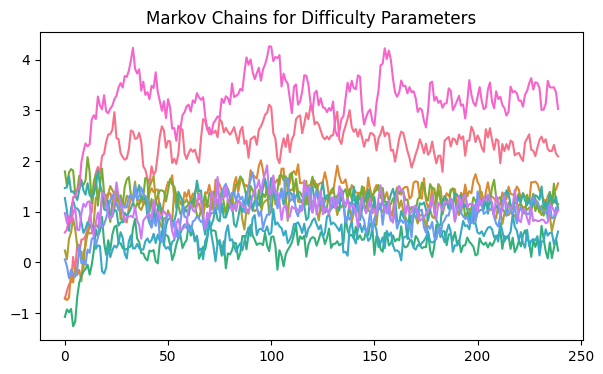

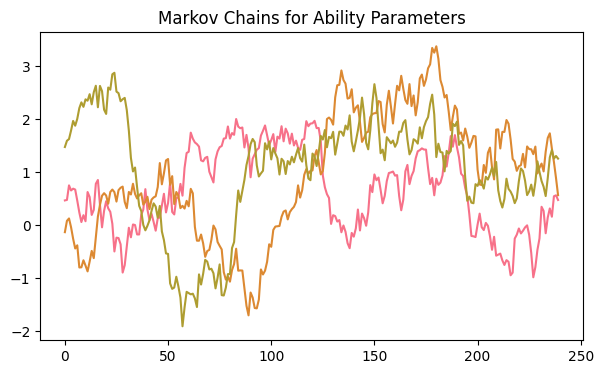

In [4]:
b_chain = pd.DataFrame(np.array(accepted_b).reshape((len(accepted_b), n_items)))
theta_chain = pd.DataFrame(np.array(accepted_theta).reshape((len(accepted_theta), n_students)))

plt.rcParams["figure.figsize"] = (7,4)
sns.set_palette("husl", 10)

plt.title('Markov Chains for Difficulty Parameters')
plt.plot(b_chain)
plt.show()

plt.title('Markov Chains for Ability Parameters')
plt.plot(theta_chain.sample(3, axis='columns'))
plt.show()

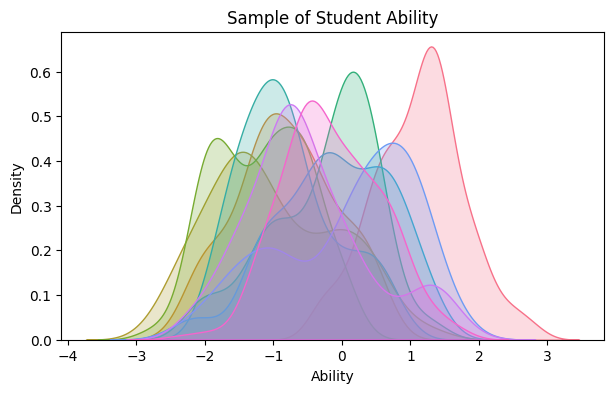

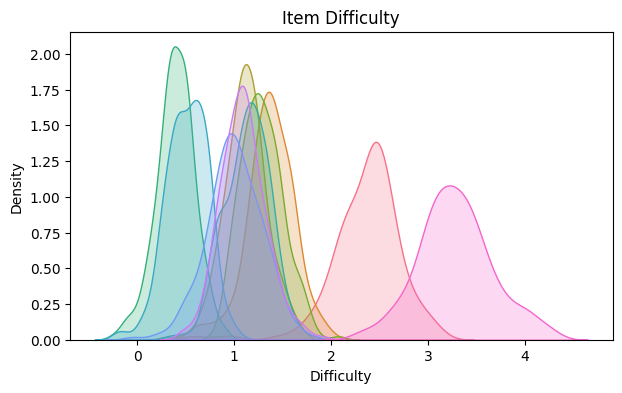

In [16]:
plt.rcParams["figure.figsize"] = (7,4)

for i in np.random.choice(n_students, 10, replace=False):
    sns.kdeplot(theta_chain.iloc[10:,i], fill=True)
plt.title('Sample of Student Ability')
plt.xlabel('Ability')
plt.ylabel('Density')
plt.show()

for i in range(n_items):
    sns.kdeplot(b_chain.iloc[10:,i], fill=True)
plt.title('Item Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Density')
plt.show()


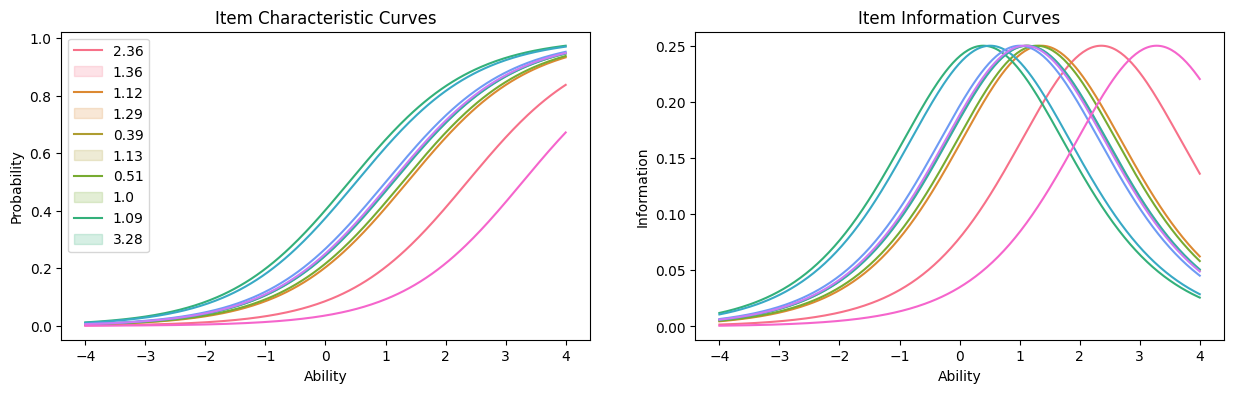

In [17]:
# final values
theta_final = theta_chain.iloc[10:].mean()
b_final = b_chain.iloc[10:].mean()

# item characteristic curve
def icc_1pl(theta, b):
    return 1 / (1 + np.exp(-(theta - b)))

# item information curve
def inf_1pl(p_theta):
    return p_theta * (1 - p_theta)

plt.rcParams["figure.figsize"] = (15,4)
sns.set_palette("husl", 10)
f, (ax1, ax2) = plt.subplots(1, 2)

theta = np.linspace(-4, 4, 256, endpoint=True)

for b in b_final:
    p_theta = icc_1pl(theta, b)
    sns.lineplot(x=theta, y=p_theta, ax=ax1)
    sns.lineplot(x=theta, y=inf_1pl(p_theta), ax=ax2)

ax1.set_title('Item Characteristic Curves')
ax1.set_xlabel('Ability')
ax1.set_ylabel('Probability')

ax2.set_title('Item Information Curves')
ax2.set_xlabel('Ability')
ax2.set_ylabel('Information')

ax1.legend(b_final.round(2))

plt.show()


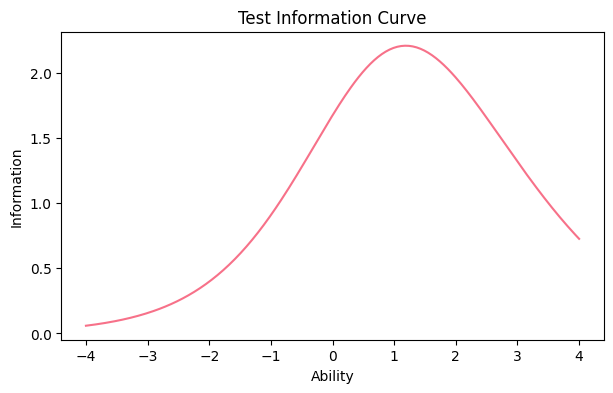

In [18]:
# Test Information Curve

test_inf = []
for b in b_final:
    p_theta = icc_1pl(theta, b)
    test_inf.append(inf_1pl(p_theta))

plt.rcParams["figure.figsize"] = (7,4)
plt.plot(theta, np.sum(test_inf, axis=0))

plt.title('Test Information Curve')
plt.xlabel('Ability')
plt.ylabel('Information')

plt.show()

# References

1. https://quantdev.ssri.psu.edu/tutorials/introduction-irt-modeling

2. https://www.youtube.com/watch?v=SrdbllMYq8M&list=PLJNUIJnElUzDmrIPunMyF3tTvIHb65wNb&index=1

